In [1]:
import os
import pandas as pd
import json
import folium
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  
%load_ext autoreload
%autoreload 2

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO



# Question 1
## Part 1: A naive analysis

We load the data and compare the outcome for the two groups (participants and non-participants).

In [50]:
df_full = pd.read_csv('lalonde.csv')
df_full.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [65]:
df_treat_1 = df_full[df_full.treat == 1]
df_treat_0 = df_full[df_full.treat == 0]
df_treat_1.name = 'outcome_participants'
df_treat_0.name = 'outcome_nonparticipants'
print('Descriptive statistics for the outcome for participants:')
print(df_treat_1['re78'].describe())
print('\n\nDescriptive statistics for the outcome for non-participants:')
print(df_treat_0['re78'].describe())

Descriptive statistics for the outcome for participants:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


Descriptive statistics for the outcome for non-participants:
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64


In [66]:
print('Descriptive statistics for all real earnings in 1974:')
print(df_full.re74.describe())
print('\n\nDescriptive statistics for all real earnings in 1975:')
print(df_full.re75.describe())

Descriptive statistics for all real earnings in 1974:
count      614.000000
mean      4557.546569
std       6477.964479
min          0.000000
25%          0.000000
50%       1042.330000
75%       7888.498250
max      35040.070000
Name: re74, dtype: float64


Descriptive statistics for all real earnings in 1975:
count      614.000000
mean      2184.938207
std       3295.679043
min          0.000000
25%          0.000000
50%        601.548400
75%       3248.987500
max      25142.240000
Name: re75, dtype: float64


Now we will plot the histograms of the outcome variable for the two groups (participants and non-participants) side by side (0 is untreated and 1 is treated):

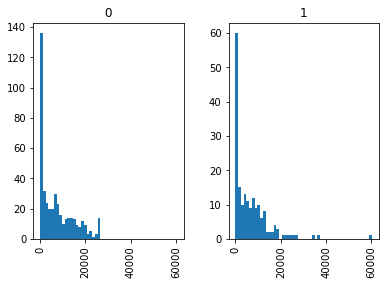

In [67]:
ax1, ax2 = df_full.hist(column='re78', by = 'treat', range=[0, df_full.re78.max()], bins = 50)


Number of participants with a higher 1978 earning than the maximum 1978 earning of non-participants:

In [69]:
df_treat_1[df_treat_1.re78 > df_treat_0.re78.max()].shape[0]

5

To the naive researcher [*tries hard to sound naive*] it seems that those who have not received the training actually have higher incomes because the mean is higher for the non-participants, and also, although the 25% quartile is higher for the participants, the 50% and 75% quartiles are considerably higher for the non-participants. Also, although the non-participants seem to have a much lower maximum, the number of participants who actually attain values higher than the maximum for the non-participants is only 5, which is a very small number of people. So basically, according to the naive researcher we're roleplaying as, the training program *backfired* and actually left the participants worse off than they would have been without the training.

## Part 2: Let's start acting like the ADA students we are

We will now compare the distributions of all variables across the treatment and control groups.

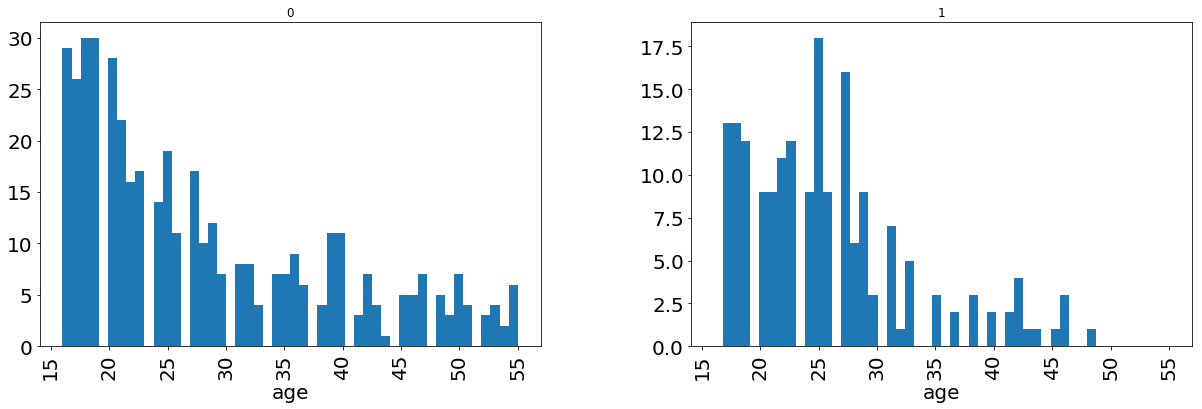

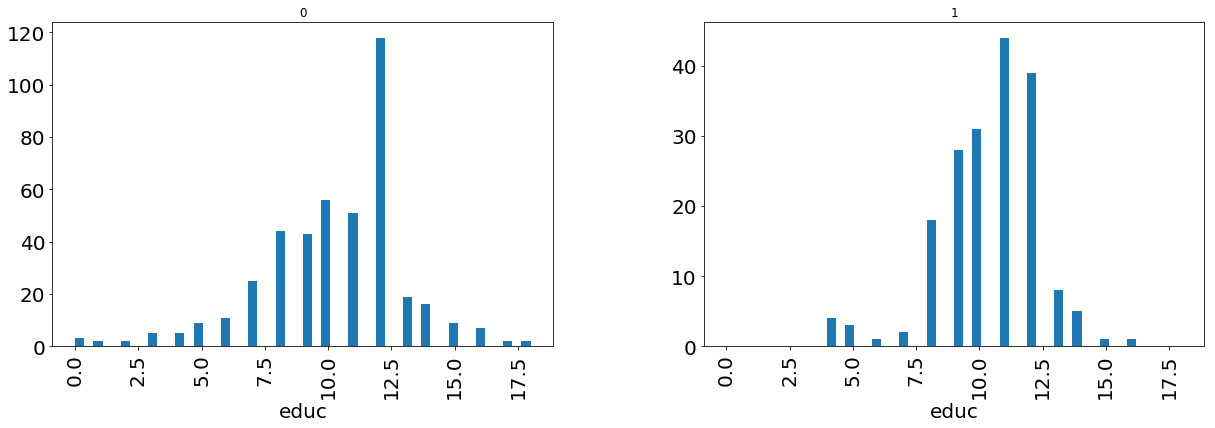

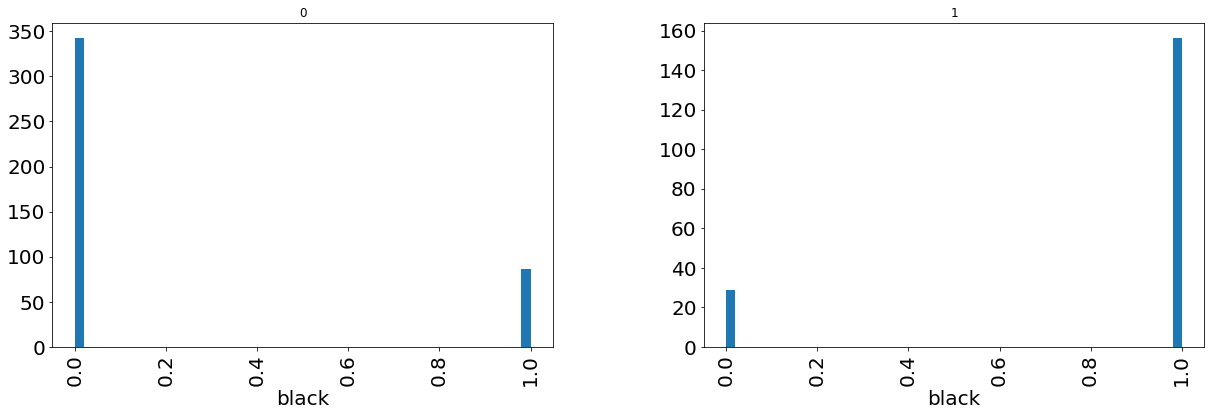

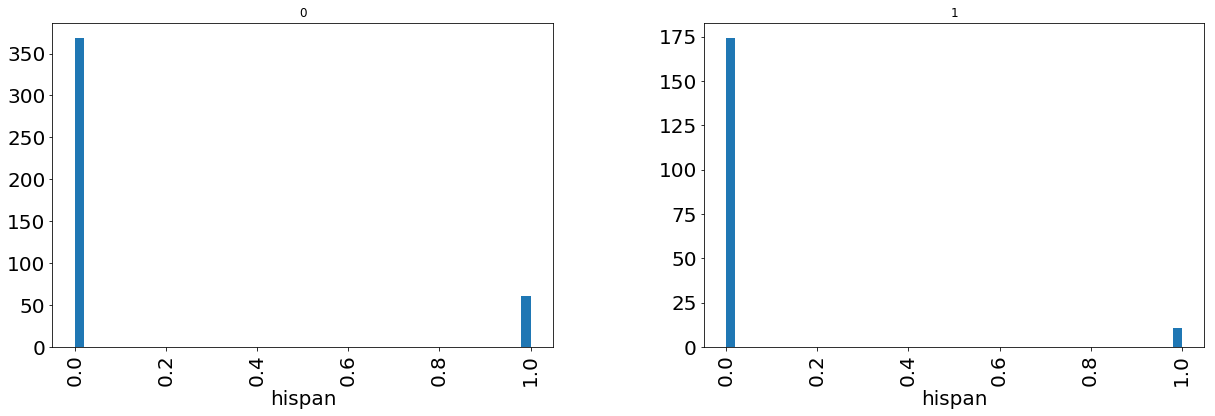

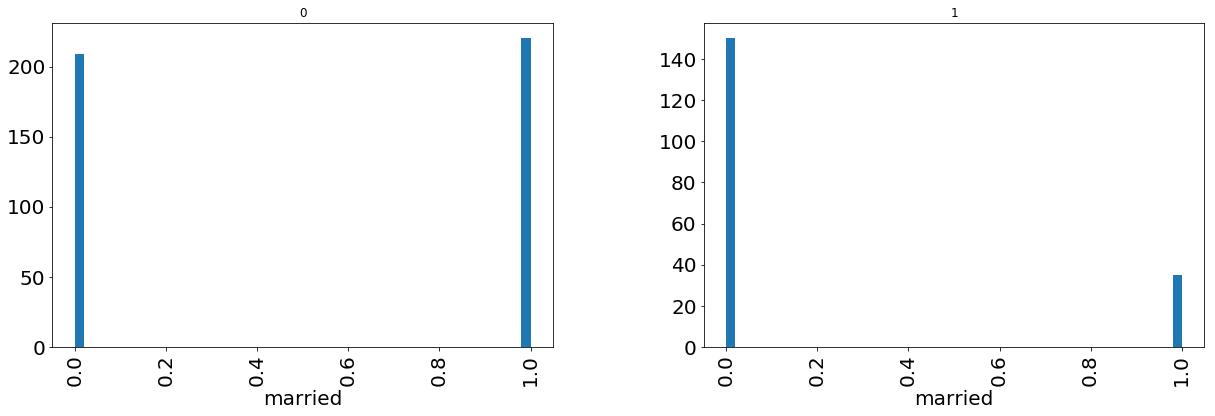

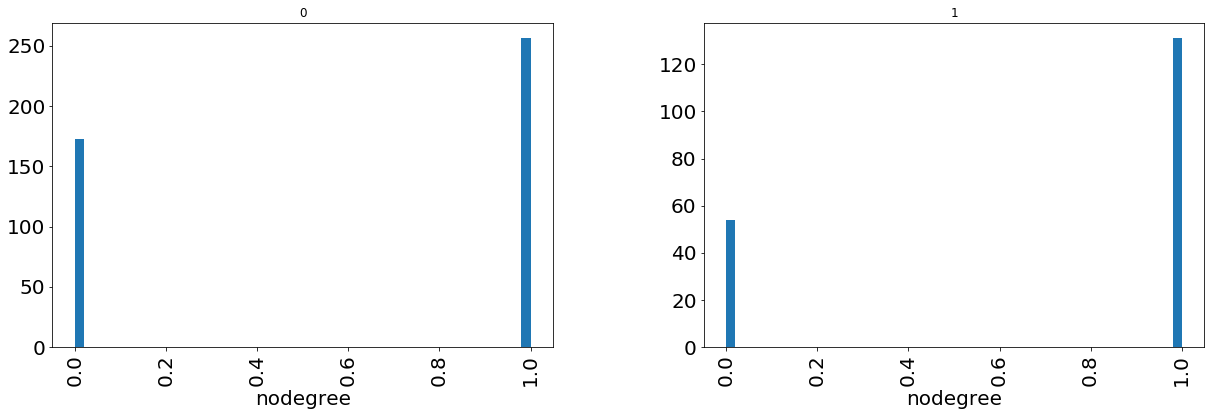

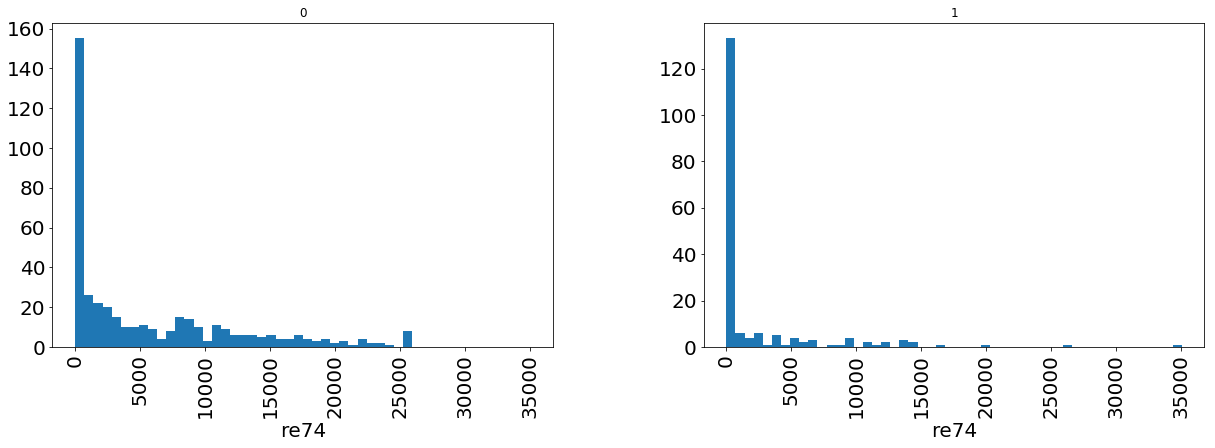

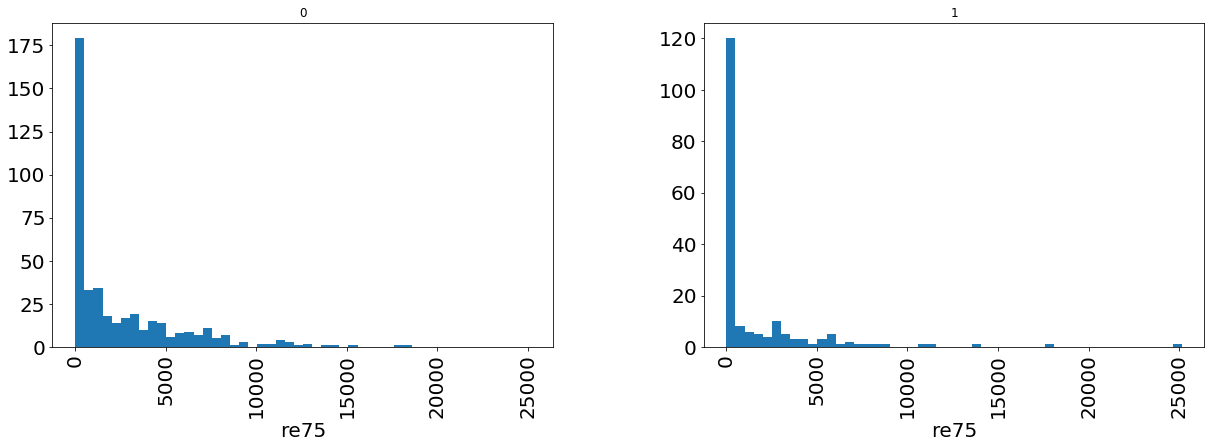

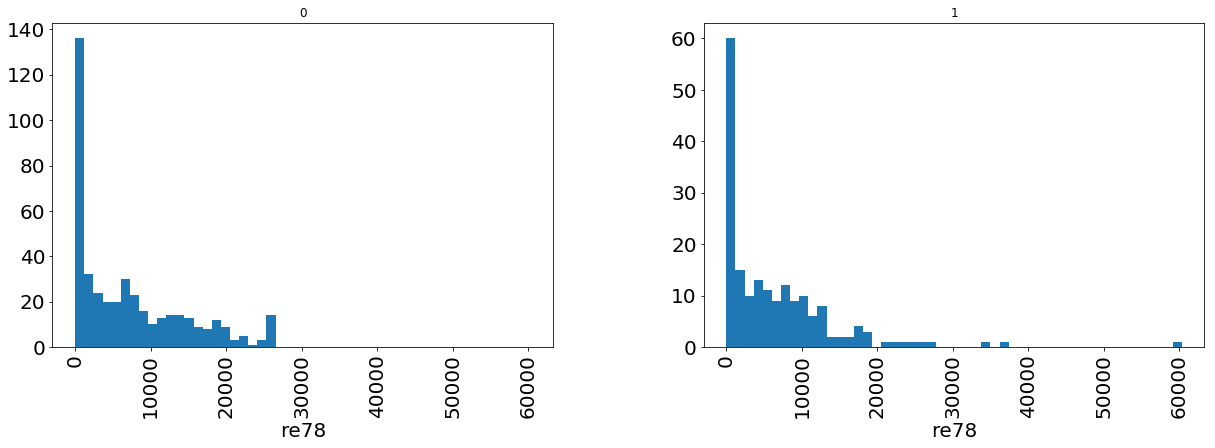

In [126]:
#plt.subplot(7,2,1)
#fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True)
def create_subplot(df, column_name):
    ax1, ax2 = df.hist(column=column_name, by='treat', range=[df[column_name].min(), df[column_name].max()], bins=50, figsize=(20,6), xlabelsize=20, ylabelsize=20)
    ax1.set_xlabel(column_name, size=20)
    ax2.set_xlabel(column_name, size=20)

for column_name in df_full.columns:
    if (column_name == 'id' or column_name == 'treat'):
        continue
    create_subplot(df_full, column_name)


The two groups seem unbalanced in three variables: black (0 for non-black, 1 for black), married (1 for married, 0 for not), and education. They are especially unbalanced in the black variable, where most of the control group are non-black and the majority of the treatment group are black. This means that existing differences in pay between different racial groups could be affecting our conclusions (not our conclusions though - the conclusions of the naive researcher in part 1). Let us see descriptive statistics for these 3 variables across the two groups in greater detail.

The first variable, black, is a Bernoulli random variable, so the mean is going to be meaningful (sorry for the pun). You can see the great difference between the two groups:

In [133]:
print('Treatment mean\n')
print(df_treat_1.black.mean())
print('\n\nControl mean\n')
print(df_treat_0.black.mean())

Treatment mean

0.8432432432432433


Control mean

0.20279720279720279


The second, married, is also a Bernoulli variable:

In [134]:
print('Treatment mean\n')
print(df_treat_1.married.mean())
print('\n\nControl mean\n')
print(df_treat_0.married.mean())

Treatment mean

0.1891891891891892


Control mean

0.5128205128205128


The third, education, looks relatively close to a Gaussian, albeit skewed (but bear in mind that it's discrete!).

In [135]:
print('Treatment\n')
print(df_treat_1.educ.describe())
print('\n\nControl\n')
print(df_treat_0.educ.describe())

Treatment

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64


Control

count    429.000000
mean      10.235431
std        2.855238
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64
